In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
import re
import shutil
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, jaccard_score, f1_score, homogeneity_completeness_v_measure, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, pairwise_distances
from sklearn.cluster import estimate_bandwidth
import numpy as np
from collections import defaultdict
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy
from scipy.optimize import linear_sum_assignment
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en_core_web_sm
nlp_en = spacy.load("en_core_web_sm") # english pipeline
nlp_es = spacy.load("es_core_news_sm") # spanish pipeline


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [2]:
import pygame
import sys
import numpy as np
from constants import *
from Point import Point
from Plot import Plot
from scale import Scale

pygame 2.5.2 (SDL 2.28.3, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
BERT_PATH = "bert-base-uncased"
#root_drive = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/'

In [6]:
hidden_size = 2  # size of fixed vector
#vector_representations = torch.load(root_drive + BERT_PATH + str(hidden_size) + '_vector_representations_LSTM.pth')
vector_representations = torch.load(BERT_PATH + str(hidden_size) + '_vector_representations_LSTM.pth')
num_sentences = 1379

In [ ]:
!wget -O Stsbenchmark.tar.gz http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
shutil.unpack_archive('./Stsbenchmark.tar.gz', extract_dir='./', format='gztar')

In [7]:
def getSTSBenchmarkSents(filename='sts-train.csv', root='stsbenchmark/', encoding='utf-8'):
  f = open(root+filename, 'r', encoding=encoding)
  s1, s2, target = [], [], []
  for line in f:
    example = re.split(r'\t+', line)
    if len(example) > 7:
      example = example[:-2]
    s2.append(example[-1])
    s1.append(example[-2])
    target.append(float(example[-3]))
  print("{} samples: {}".format(filename, len(target)))
  return s1, s2, target

In [8]:
s1_test,s2_test,target_test= getSTSBenchmarkSents(filename='sts-test.csv')
test = [(s1,s2_test[i],target_test[i]) for i, s1 in enumerate(s1_test)]

sts-test.csv samples: 1379


In [9]:
len(vector_representations) #(num_sentence,layer)

16548

In [10]:
def get_representations_per_layer(num_sentences, vector_representations, layers = 12):
  vectors_per_layer = {}
  labels = {}
  for l in range(layers):
    #vectors_per_layer[l] = np.array([vector_representations[(i,l)]['vector'].detach().numpy() for i in range(num_sentences)])
    vectors_per_layer[l] = np.array([vector_representations[(i,l)]['vector'] for i in range(num_sentences)])
  labels = { i: vector_representations[(i,0)]['label'][0].item() for i in range(num_sentences)}
  return vectors_per_layer, labels

In [11]:
vectors_per_layer, labels = get_representations_per_layer(num_sentences, vector_representations)

In [12]:
len(vectors_per_layer[0])

1379

In [13]:
# Guardar el diccionario en un archivo
#torch.save(vectors_per_layer, root_drive + BERT_PATH + str(hidden_size) + '_vectors_per_layer_LSTM.pth')
torch.save(vectors_per_layer, BERT_PATH + str(hidden_size) + '_vectors_per_layer_LSTM.pth')

In [14]:
def plot_clustering(X, clusters, algorithm, labels, text, plot_size = (12,12)):
    n_clusters = len(np.unique(clusters))
    print("Clusters number: ", n_clusters)
    plt.figure(figsize=plot_size)
    # Obtén una paleta de colores para asignar a los clusters
    cmap = plt.cm.get_cmap('tab20', n_clusters)

    # Grafica los puntos y asigna colores diferentes a cada cluster
    for cluster in range(n_clusters):
        cluster_points = X[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(cluster))#s = 12
        if text == 'cluster':
          for x, y in cluster_points:
            plt.text(x, y, str(cluster), color='black', fontsize=8, ha='center', va='center')

    if text == 'label':
      for i, (x, y) in enumerate(X):
          plt.text(x, y, str(labels[i]), color='black', fontsize=8, ha='center', va='center')
    elif text == 'index':
      for i, (x, y) in enumerate(X):
          plt.text(x, y, str(i), color='black', fontsize=8, ha='center', va='center')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(algorithm + ' Clustering')
    plt.show()

In [15]:
def clustering(vectors_per_layer, layer, labels, algorithm='MeanShift', threshold = 0.025, min_samples = 2, text = '', plot_size = (12,12)):
  # Datos de ejemplo
  positions = {}
  X = vectors_per_layer[layer]
  if algorithm == 'WARD':
    # Ajusta el algoritmo de Ward
    linkage_matrix = linkage(X, method='ward')
    clusters = fcluster(linkage_matrix, threshold, criterion='distance')#0.025
  elif algorithm == 'MeanShift':
    # Aplicar el algoritmo MeanShift
    bandwidth = estimate_bandwidth(X, quantile=0.3)
    print(bandwidth)
    model = MeanShift(bandwidth=threshold) #0.0025
    clusters = model.fit_predict(X)
  else:
    # Aplicar el algoritmo DBSCAN
    model = DBSCAN(eps=threshold, min_samples=min_samples) #0.001
    clusters = model.fit_predict(X)

  for i in range(len(np.unique(clusters))):
    positions[i] = np.where(clusters == i)[0]

  plot_clustering(X, clusters, algorithm, labels, text, plot_size = plot_size)
  return positions, len(np.unique(clusters))



In [16]:
def subclustering(vectors, positions, data, layer, cluster_number, report = False, plot_size = (12,12)):
  sentences = []
  for i in positions[cluster_number]:
    sentences.append(data[i])
    if report:
      print(str(i) + '   ' + data[i][0] + '    ' + data[i][1].strip() + '   ' + str(data[i][2]))

  if report:
    cluster = np.array([list(vectors[layer][i]) for i in positions[cluster_number]])
    plt.figure(figsize=plot_size)
    plt.scatter(vectors[layer][:, 0], vectors[layer][:, 1], color = 'gray')#s = 12
    plt.scatter(cluster[:, 0], cluster[:, 1], color = 'red')#s = 12

  return sentences

Código para análisis gramatical

In [17]:
def get_gramatical_structure(sentence):
    doc = nlp_en(sentence)
    structure = tuple(token.dep_ for token in doc)
    return structure

def compare_structures(sentences):
    structures = defaultdict(list)
    for sentence in sentences:
        structure = get_gramatical_structure(sentence)
        structures[structure].append(sentence)
    return structures

def report_structures(structures):
    print("Cantidad de oraciones con la misma estructura gramatical:")
    print()
    for structure, sentences in structures.items():
        print(f"Estructura: {structure}, Cantidad: {len(sentences)}")
        print("Oraciones:")
        for sentence in sentences:
            print(sentence)
        print()

def measure_percentange_structure(sentences, structures, most_common = 5):
  # solo se reporta la estructura más popular dentro de un conjunto de oraciones dado
  struc = []
  sorted_values = sorted([(k,len(v)) for k,v in structures.items()], key=lambda x: x[1], reverse=True)[:most_common]
  for (k,v) in sorted_values:
    #print("{} oraciones de {} tienen la misma estructura gramatical".format(v,len(sentences)))
    #print("El {}% de las oraciones tienen la misma estructura gramatical".format(round(v/len(sentences),4)*100))
    struc.append(k)
    print("El {}% de las oraciones del cluster ({}/{}) tienen la estructura gramatical: {}".format(round(v/len(sentences)*100,3),v,len(sentences),k))
  return struc, sorted_values


def get_grammatical_structure_analysis(sentences, most_common = 3, print_report = False):
  structures = compare_structures(sentences)
  #print(structures)
  if print_report:
    report_structures(structures)
  return measure_percentange_structure(sentences, structures, most_common)

def measure_percentange_structure_global(all_sentences, all_structures, structures):
  for structure in structures:
    num = len(all_structures[structure])
    print("El {}% del total de las oraciones ({}/{}) tienen la estructura gramatical: {}".format(round(num/len(all_sentences)*100,3),num,len(all_sentences),structure))


def grammatical_structure_analysis(all_sentences_processed, sentences_processed, all_structures, most_common = 3, print_report = False):
  structures, sorted_values = get_grammatical_structure_analysis(sentences_processed, most_common = most_common, print_report = print_report)
  print()
  measure_percentange_structure_global(all_sentences_processed, all_structures, structures)
  print()
  for idx, structure in enumerate(structures):
    (k,v) = sorted_values[idx]
    num = len(all_structures[structure])
    print("El {}% de las oraciones agrupadas en el cluster ({}/{}) del total de las oraciones con estructura: {}".format(round(v/num*100,3),v,num,structure))

In [ ]:
test

Buscar palabra

In [18]:
def find_keyword_in_sentences(test, keyword):
  indexes = []
  rest = []
  for index, (s1,s2,score) in enumerate(test):
    if keyword in s1 or keyword in s2:
      indexes.append(index)
    else:
      rest.append(index)
  return indexes, rest

In [19]:
indices_find_keyword, _= find_keyword_in_sentences(test, 'law')
indices_find_keyword

[331, 582, 911, 941, 971, 973, 974, 984, 1024, 1037, 1104, 1251]

In [105]:
def plot_sentences_with_same_word(vectors, keyword, data, layer, plot_size = (12,12)):
    positions, rest = find_keyword_in_sentences(data, keyword)
    cluster = np.array([list(vectors[layer][i]) for i in positions])
    print(len(cluster))
    _rest = np.array([list(vectors[layer][i]) for i in rest])
    plt.figure(figsize=plot_size)
    #plt.scatter(vectors[layer][:, 0], vectors[layer][:, 1], color = 'gray')#s = 12
    plt.scatter(_rest[:, 0], _rest[:, 1], color = 'gray')#s = 12
    plt.scatter(cluster[:, 0], cluster[:, 1], color = 'red')#s = 12
    for i in positions:
      #print(str(i) +': ' + data[i][0] + ', ' + data[i][1] + ', ' + data[i][2])
      print("{} : {}.".format(str(i), data[i]))
    for idx, (x, y) in enumerate(cluster):
      plt.text(x,y, str(positions[idx]), color='black', fontsize=8, ha='center', va='center')

In [37]:
def get_sents_with_same_word(vectors, keyword, data, layer, plt):
    points = []

    positions, r = find_keyword_in_sentences(data, keyword)
    for i, idx in enumerate(r + positions):
        if i < len(r):
            points.append(Point(np.array(vectors[layer][idx]), plt, idx, data[idx][0] + ' - ' + data[idx][1].replace("\n", ""), data[idx][2], GRAY))
        else:
            points.append(Point(np.array(vectors[layer][idx]), plt, idx, data[idx][0] + ' - ' + data[idx][1].replace("\n", ""), data[idx][2], BLUE))
    return points

Código para análisis de tópicos

In [22]:
def find_topics(preprocessed_sents, num_topics = 5, words_in_topics = 3):
  # Inicializar el vectorizador TF-IDF
  vectorizer = CountVectorizer()
  # Calcular las características TF-IDF para las oraciones
  term_counts = vectorizer.fit_transform(preprocessed_sents)
  #print(features)
  # Obtener las características únicas (palabras) del corpus
  features = vectorizer.get_feature_names_out()
  #print(features)

  # Definir el modelo LDA y ajustarlo al conjunto de sentencias
  lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
  lda.fit(term_counts)

  # Obtener los tópicos principales
  #lda.components_ es una matriz que contiene la distribución de palabras en cada tópico. Cada fila = tópico y cada columna = una palabra en vocabulario.
  #argsort(axis=1) ordena los índices de las palabras en cada fila (tópico) en orden ascendente.
  #[:, ::-1] invierte el orden de los índices en cada fila (tópico), de modo que las palabras más relevantes van primero.
  top_topics = lda.components_.argsort(axis=1)[:, ::-1]
  feature_names = vectorizer.get_feature_names_out()
  #print(top_topics) #top_topics it is an array (num_topics, words)
  topics_ = []
  for topic_idx, topic in enumerate(top_topics):
      top_words = [feature_names[i] for i in topic[:words_in_topics]]  # Las palabras más relevantes del tópico
      topics_.append(top_words)
      print(f"Tópico {topic_idx + 1}: {' '.join(top_words)}")
  return topics_


def print_sentences_with_topics(sentences,preprocessed_sents, topics, print_report = True):
    sents_len = []
    for j, sentence in enumerate(preprocessed_sents):
      for topic in topics:
        if topic in sentence:
            sents_len.append((j,sentences[j]))
    sents_len = list(OrderedDict.fromkeys(sents_len))
    if print_report:
      for t in sents_len:
        print(f"Sentence {t[0]}: {t[1]}")
    return sents_len

def print_topics_analysis(sentences, preprocessed_sents, all_sents_text_preprocessed, topics, print_report = False):
  sents_with_topic = print_sentences_with_topics(sentences,preprocessed_sents, topics, print_report = print_report)
  print()
  print("Hay {}/{} ({}%) sentencias en el cluster con el tópico {}".format(len(sents_with_topic), len(sentences), round((len(sents_with_topic)/len(sentences)*100),3),topics))
  all_sents_with_topic = print_sentences_with_topics(test,all_sents_text_preprocessed, topics, print_report = print_report)
  print("Hay {}/{} ({}%) sentencias en total que hablan del tópico {}".format(len(all_sents_with_topic), len(test), round(len(all_sents_with_topic)/len(test)*100,3),topics))
  print("Hay {}/{} ({}%) sentencias en el cluster con el tópico {} considerando todas las sentencias".format(len(sents_with_topic), len(all_sents_with_topic), round((len(sents_with_topic)/len(all_sents_with_topic)*100),3),topics))


def topics_analysis(sentences, all_sents_text_preprocessed, preprocessed_sents, num_topics = 5, words_in_topics = 3, type_analysis ='by_word', print_report = False):
  topics = []
  if type_analysis =='by_word':
    topics_array = find_topics(preprocessed_sents, num_topics = num_topics, words_in_topics = words_in_topics)
    topics = list(set(np.ravel(topics_array).tolist()))
  if type_analysis =='by_topic':
    topics = find_topics(preprocessed_sents, num_topics = num_topics, words_in_topics = words_in_topics)
  for topic in topics:
    t = [topic] if type(topic) == str else topic
    print_topics_analysis(sentences, preprocessed_sents, all_sents_text_preprocessed, t, print_report = print_report)

In [23]:
def sentences_processing(sentences,which_sentence='join',has_text_processing=False,has_stopwords=True,lemmatize=False,has_numbers=True,has_punctuation=True):
  sents = []
  lemmatizer = WordNetLemmatizer()

  for i in range(len(sentences)):
    if which_sentence == 'join':
      sents.append(sentences[i][0] + ' ' + sentences[i][1].strip())
    elif which_sentence == 's1':
      sents.append(sentences[i][0])
    elif which_sentence == 's2':
      sents.append(sentences[i][1].strip())

  if not has_text_processing:
    return sents
  else:
    processed_text = []
    for text in sents:
      if not has_numbers:
        text = re.sub(r'\d+', '', text)
      if not has_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
      tokens = word_tokenize(text.lower())
      if not has_stopwords:
        stop_words = nltk.corpus.stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]
      if lemmatize:
        text = ' '.join(tokens)
        doc = nlp_en(text)
        tokens = [token.lemma_ for token in doc]
        #tokens = [lemmatizer.lemmatize(token) for token in tokens]
      processed_text.append(' '.join(list(OrderedDict.fromkeys(tokens)))) #eliminar palabras repetidas en misma secuencia
    return processed_text

In [24]:
# here goes all the type of analysis
def cluster_analysis(all_sentences, cluster_sentences, all_structures, all_sents_text_preprocessed, preprocessed_sents_text, most_common_structures = 2, num_topics = 3, words_in_topics = 2, which_sentence = 'join', type_analysis = 'by_word', gramatical_structure_report = False, topics_report = False):
  #processing
  all_sentences_processed = sentences_processing(all_sentences, which_sentence)
  sentences_processed = sentences_processing(cluster_sentences, which_sentence)

  print("Total de sentencias en cluster: " + str(len(cluster_sentences)) + '\n')
  print("Análisis de estructura gramatical: \n")
  grammatical_structure_analysis(all_sentences_processed, sentences_processed, all_structures, most_common = most_common_structures, print_report = gramatical_structure_report)
  print()
  #print("Análisis de Tópicos: \n")
  #topics_analysis(cluster_sentences, all_sents_text_preprocessed, preprocessed_sents_text, num_topics = num_topics, words_in_topics = words_in_topics, type_analysis = type_analysis, print_report = topics_report)

In [25]:
all_sents_text_preprocessed = sentences_processing(test,which_sentence='join',has_text_processing=True,has_stopwords=False,lemmatize=True,has_numbers=False,has_punctuation=False)
all_sentences_processed = sentences_processing(test, which_sentence='join')
all_structures = compare_structures(all_sentences_processed)

16
33 : ('A cat is eating some corn.', 'A cat is eating corn on the cob.\n', 4.25).
34 : ('A man is eating a food.', 'A man is eating a piece of bread.\n', 3.4).
35 : ('A man is playing a guitar.', 'A man is eating pasta.\n', 0.533).
124 : ('A baby elephant is eating a small tree.', 'A little girl peddling a scooter.\n', 0.0).
164 : ('The man is eating.', 'A man is eating food.\n', 4.6).
184 : ('A dog is playing with a toy.', 'A dog is eating a doll.\n', 2.25).
222 : ('An okapi is eating from a tree.', 'A moose drinks from a sprinkler.\n', 0.333).
238 : ('A person is putting shredded cheese in a pot.', 'A hamster is eating some seeds.\n', 0.25).
243 : ('The girl is carrying a baby.', 'A man is eating a food.\n', 0.0).
284 : ('A yellow bird is eating fruit on a wire grate.', 'A yellow bird eating fruit on a bird feeder.\n', 2.8).
288 : ('A small brown birds is eating from a bird feeder hanging from a tree.', 'A small bird perches on the bird feeder hanging from the tree.\n', 3.8).
291 :

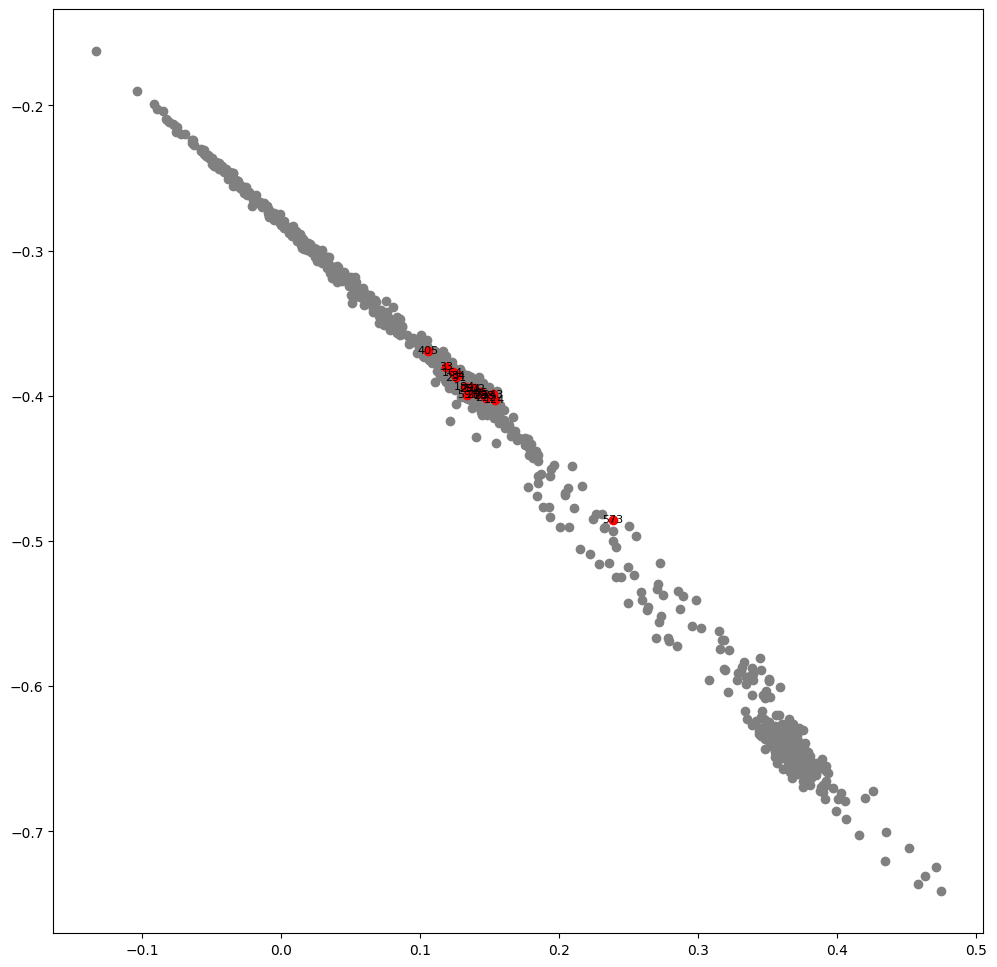

In [197]:
layer = 11
plot_sentences_with_same_word(vectors_per_layer, ' eating', test, layer)

In [177]:
# Inicializar pygame
pygame.init()
# Crear la ventana
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Clustering")
# Crear el cuadro de referencia
ploot = Plot(PLOT_DIMS[0], PLOT_DIMS[1], PLOT_DIMS[2], PLOT_DIMS[3], 3, 3)
points = get_sents_with_same_word(vectors_per_layer, ' blue', test, layer, ploot)

def is_clicked(mouse_pos):
    x, y = mouse_pos
    for i, point in enumerate(points):
        px, py, pr = point.data['scale_position'][0], point.data['scale_position'][1], point.data['style']['width'] / 2
        if px - pr <= x <= px + pr and py - pr <= y <= py + pr:
            point.data['style']['color'] = RED
            print("{} , {} , {}".format(point.data['id'],point.data['sequence'],point.data['similarity']))


scale = Scale(points)
scale.calculate_scale()

for p in points:
    p.data['scale_position'] = scale.scaling(p.data['position'])

# Bucle principal
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            if event.button == 1:  # Verificar si se hizo clic con el botón izquierdo del ratón
                mouse_pos = pygame.mouse.get_pos()
                point_id = is_clicked(mouse_pos)


    # Limpiar la pantalla
    screen.fill(WHITE)
    # Dibujar el cuadro de referencia
    ploot.draw(screen,scale)

    # Dibujar los points en relación con el cuadro de referencia
    for punto in points:
        punto.draw(screen)

    pygame.display.flip()

# Salir del juego
pygame.quit()
sys.exit()


890 , Chiron already has nearly 20 percent acceptances from PowderJect's shareholders. - Chiron has acceptances from holders of nearly 20 percent of PowderJect shares. , 3.667
960 , IDEC shareholders would own 50.5 percent of the stock of the combined company, and Biogen shareholders the remaining 49.5 percent. - The companies said Idec holders would own about 50.5 percent of the stock of the combined company. , 3.0
1068 , Kollar-Kotelly has scheduled another antitrust settlement compliance hearing for January. - The judge scheduled another oversight hearing for late January. , 2.8
1084 , They said they had concluded that the film failed "to present a balanced portrayal" of the Reagans. - CBS said the show "does not present a balanced portrayal of the Reagans for CBS and its audience. , 3.0
1111 , The research firm earlier had forecast an increase of 4.9 percent. - The firm had predicted earlier this year a 4.9 percent increase. , 4.8
1115 , The Episcopal Diocese of Central Florida bec

SystemExit: 

0.1216510160931073
Clusters number:  20


/var/folders/qd/hrmd3lpn7jx1ndxd2z1f8l080000gn/T/ipykernel_42896/3182682383.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_clusters)


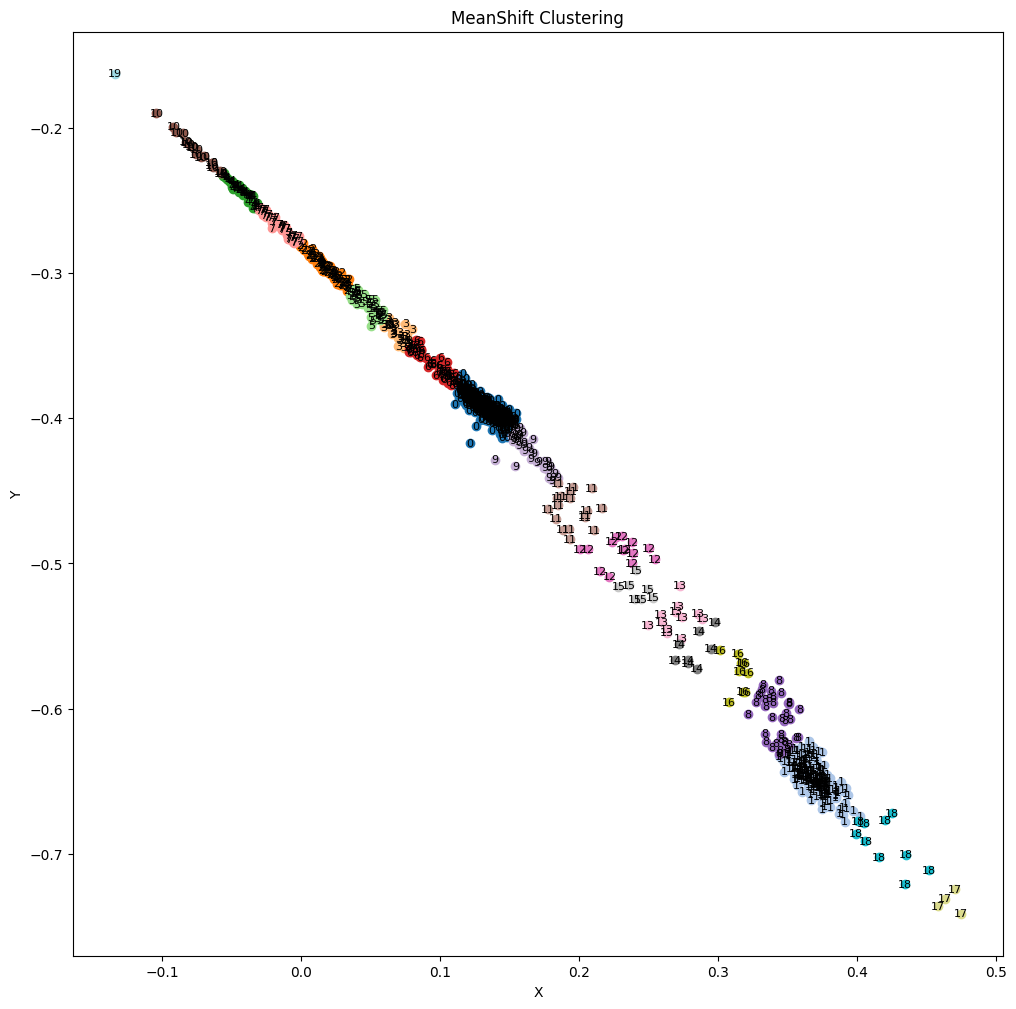

In [200]:
layer = 11 #0.004
indices, num_clusters = clustering(vectors_per_layer, layer, labels, threshold = 0.02, text = 'cluster')#threshold = 0.01, 0.004

1   A group of men play soccer on the beach.    A group of boys are playing soccer on the beach.   3.6
16   A baby panda goes down a slide.    A panda slides down a slide.   4.4
22   Two zebras play in an open field.    Two zebras are playing in a field.   4.2
31   A young woman is putting stickers all over her face.    A woman is applying stickers to her face.   4.8
38   A woman is dancing in the rain.    A woman dances in the rain out side.   5.0
40   A man mixes vegetables in a pot.    A person is stirring vegetables in a pot.   3.75
63   A woman is playing in the ocean.    A woman is preparing shrimp to cook.   0.75
74   The man is using a camera to hammer a nail.    Someone is banging a camera lense against a nail.   2.6
76   A boy is crawling into a dog house.    A boy is playing a wooden flute.   0.75
83   The men played follow the leader on the grass.    The rhino grazed on the grass.   1.0
85   A woman peels garlic with her hands.    The woman is slicing herbs.   1.0
90   A pe

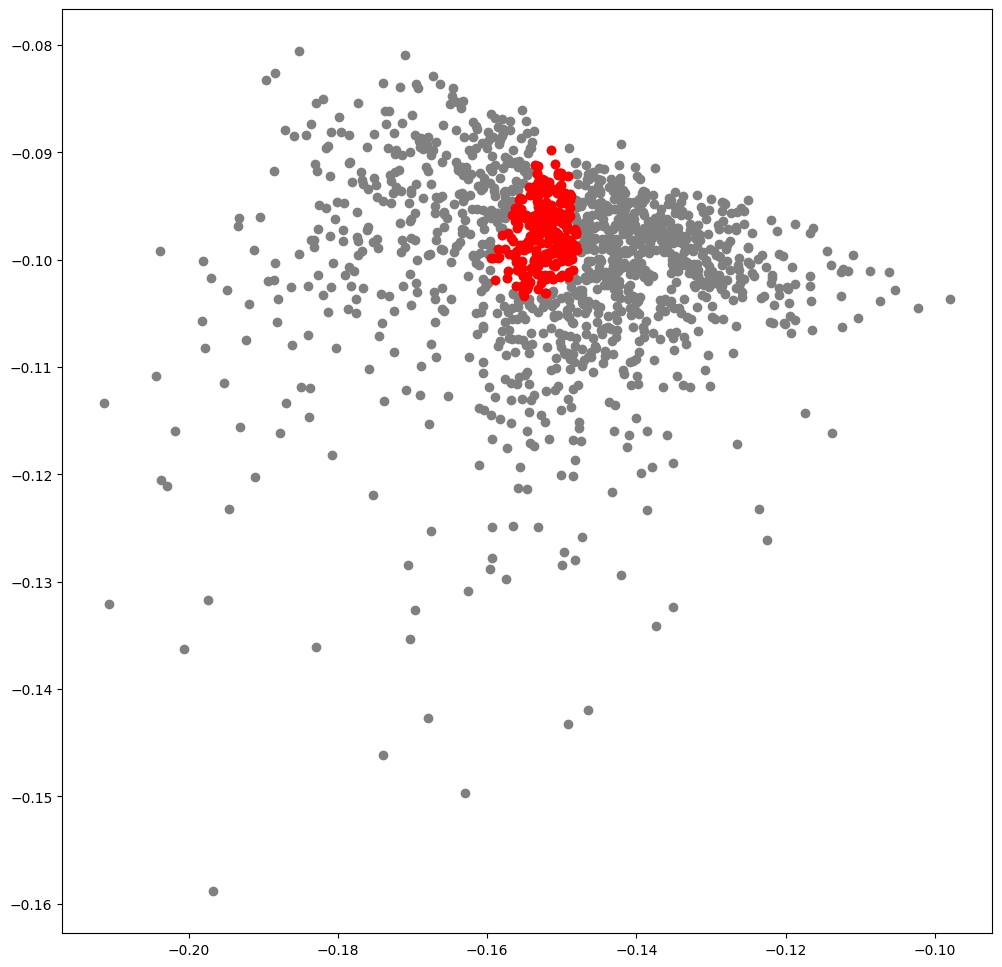

In [22]:
sentences = subclustering(vectors_per_layer, indices, test, layer, cluster_number=0, report = True)

In [ ]:
#preprocessed_sents = sentences_processing(sentences,which_sentence='join',has_text_processing=True,has_stopwords=False,lemmatize=True,has_numbers=False,has_punctuation=False)
#cluster_analysis(test, sentences, all_structures, all_sents_text_preprocessed, preprocessed_sents, most_common_structures = 2, num_topics = 3, words_in_topics = 2)

In [ ]:
for cluster in range(num_clusters):
  print()
  print('----- Cluster {} -----'.format(cluster))
  print()
  sentences = subclustering(vectors_per_layer, indices, test, layer, cluster_number=cluster, report = False)
  preprocessed_sents = sentences_processing(sentences,which_sentence='join',has_text_processing=True,has_stopwords=False,lemmatize=True,has_numbers=False,has_punctuation=False)
  cluster_analysis(test, sentences, all_structures, all_sents_text_preprocessed, preprocessed_sents, most_common_structures = 2, num_topics = 3, words_in_topics = 2)


----- Cluster 0 -----

Total de sentencias en cluster: 250

Análisis de estructura gramatical: 

El 0.4% de las oraciones del cluster (1/250) tienen la estructura gramatical: ('det', 'nsubj', 'prep', 'pobj', 'ROOT', 'dobj', 'prep', 'det', 'pobj', 'punct', 'det', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT', 'dobj', 'prep', 'det', 'pobj', 'punct')
El 0.4% de las oraciones del cluster (1/250) tienen la estructura gramatical: ('det', 'compound', 'nsubj', 'ROOT', 'prep', 'det', 'pobj', 'punct', 'det', 'nsubj', 'ROOT', 'prt', 'det', 'dobj', 'punct')

El 0.073% del total de las oraciones (1/1379) tienen la estructura gramatical: ('det', 'nsubj', 'prep', 'pobj', 'ROOT', 'dobj', 'prep', 'det', 'pobj', 'punct', 'det', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT', 'dobj', 'prep', 'det', 'pobj', 'punct')
El 0.073% del total de las oraciones (1/1379) tienen la estructura gramatical: ('det', 'compound', 'nsubj', 'ROOT', 'prep', 'det', 'pobj', 'punct', 'det', 'nsubj', 'ROOT', 'prt', 'det', 'dobj', 'punct')

El